In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
train_path = '/content/drive/MyDrive/sentiment/train.csv'
test_path = '/content/drive/MyDrive/sentiment/test.csv'

df_train = pd.read_csv(train_path, encoding='ISO-8859-1')
df_test = pd.read_csv(test_path, encoding='ISO-8859-1')

Using device: cuda


In [4]:
# Preprocessing
def preprocess_data(df):
    # Select only needed columns and drop NA
    df = df[['text', 'sentiment']].dropna()

    # Map sentiment to labels
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    df['label'] = df['sentiment'].map(label_map)

    return df

train_data = preprocess_data(df_train)
test_data = preprocess_data(df_test)

In [5]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

# Create datasets
train_dataset = SentimentDataset(
    texts=train_data.text.values,
    labels=train_data.label.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = SentimentDataset(
    texts=test_data.text.values,
    labels=test_data.label.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # 3 classes: negative, neutral, positive
)
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Training function
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), all_preds, all_labels

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device
    )
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')

    test_acc, test_loss, _, _ = eval_model(
        model,
        test_loader,
        device
    )
    print(f'Test loss: {test_loss}, accuracy: {test_acc}\n')

Epoch 1/3
----------


Training: 100%|██████████| 1718/1718 [09:42<00:00,  2.95it/s]


Train loss: 0.5679136187800914, accuracy: 0.7650655021834062


Evaluating: 100%|██████████| 221/221 [00:26<00:00,  8.48it/s]


Test loss: 0.4849105215719922, accuracy: 0.7982456140350878

Epoch 2/3
----------


Training: 100%|██████████| 1718/1718 [09:44<00:00,  2.94it/s]


Train loss: 0.40658971964792545, accuracy: 0.8395560407569141


Evaluating: 100%|██████████| 221/221 [00:26<00:00,  8.43it/s]


Test loss: 0.5082487510137967, accuracy: 0.7942840973401245

Epoch 3/3
----------


Training: 100%|██████████| 1718/1718 [09:44<00:00,  2.94it/s]


Train loss: 0.2636929826401131, accuracy: 0.9017103347889375


Evaluating: 100%|██████████| 221/221 [00:26<00:00,  8.39it/s]

Test loss: 0.5668657647605935, accuracy: 0.7823995472552349



In [9]:
# Final evaluation
_, _, y_pred, y_true = eval_model(model, test_loader, device)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

Evaluating: 100%|██████████| 221/221 [00:26<00:00,  8.48it/s]


Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.81      0.79      1001
     neutral       0.76      0.73      0.74      1430
    positive       0.83      0.82      0.83      1103

    accuracy                           0.78      3534
   macro avg       0.78      0.79      0.79      3534
weighted avg       0.78      0.78      0.78      3534



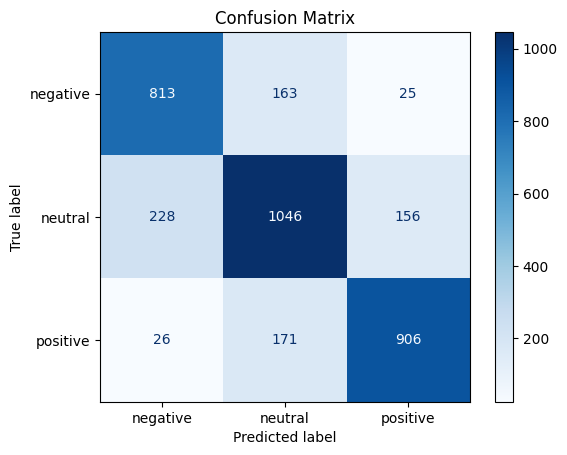

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()